# Alocação de Tarefas em Equipes Scrum usando Programação Linear Inteira

Este notebook implementa e resolve o problema de alocação de tarefas em equipes Scrum usando Gurobi. 
O problema é modelado como um **Multiple Knapsack Problem** com penalidades e precedências.

## Definição do Problema

Dada uma sprint Scrum, precisamos atribuir tarefas às pessoas da equipe, **maximizando o valor de negócio entregue** 
e **minimizando penalidades** quando uma tarefa é executada por alguém sem a habilidade adequada.

### Restrições:
- Cada pessoa tem capacidade limitada de horas
- Cada tarefa tem duração específica
- Dependência entre tarefas devem ser respeitadas
- Cada tarefa pode ser atribuída a no máximo uma pessoa

In [6]:
import gurobipy as gp
from gurobipy import GRB
import time

## Modelagem Matemática

### Conjuntos e Parâmetros:
- **P**: Conjunto de pessoas da equipe
- **T**: Conjunto de tarefas do backlog
- **D**: Subconjunto de precedências (i,j) ∈ T × T onde i precede j
- **h_i**: Duração (horas) da tarefa i
- **C_p**: Capacidade (horas disponíveis) da pessoa p
- **v_i**: Prioridade (valor) da tarefa i
- **d_i**: Penalidade se tarefa i for feita por não-especialista
- **σ_{ip}**: 1 se pessoa p é especialista na tarefa i; 0 caso contrário

### Variáveis de Decisão:
- **x_{ip}**: 1 se tarefa i é atribuída à pessoa p; 0 caso contrário
- **z_i**: 1 se tarefa i é realizada na sprint; 0 caso contrário  
- **y_{ip}**: 1 se tarefa i é feita pela pessoa p não-especialista; 0 caso contrário

### Função Objetivo:
**Maximizar:**
$$\sum_{i \in T} v_i \cdot z_i - \sum_{i \in T} \sum_{p \in P} d_i \cdot y_{ip}$$

### Restrições:

**1. Atribuição única:**
$$\sum_{p \in P} x_{ip} = z_i \quad \forall i \in T$$

**2. Capacidade das pessoas:**
$$\sum_{i \in T} h_i \cdot x_{ip} \leq C_p \quad \forall p \in P$$

**3. Ligações de habilidade:**
$$y_{ip} \geq x_{ip} - \sigma_{ip} \quad \forall i,p$$
$$y_{ip} \leq x_{ip} \quad \forall i,p$$
$$y_{ip} \leq 1 - \sigma_{ip} \quad \forall i,p$$

**4. Dependências:**
$$z_j \leq z_i \quad \forall (i,j) \in D$$

In [7]:
class AlocacaoTarefasScrum:
    """
    Sistema de alocação ótima de tarefas em equipes Scrum.
    Maximiza valor de negócio e minimiza penalidades por má alocação.
    """
    
    def __init__(self, pessoas, tarefas, capacidades, duracoes, prioridades, 
                 penalidades, especialistas, dependencias=None):
        self.pessoas = pessoas
        self.tarefas = tarefas
        self.capacidades = capacidades
        self.duracoes = duracoes
        self.prioridades = prioridades
        self.penalidades = penalidades
        self.especialistas = especialistas
        self.dependencias = dependencias if dependencias is not None else []
        
        # Variáveis de resultado
        self.modelo = None
        self.valor_otimo = None
        self.alocacao = {}
        self.tarefas_selecionadas = []
        self.penalidade_total = 0
        
    def criar_modelo(self):
        """Cria o modelo de otimização linear inteira mista."""
        self.modelo = gp.Model("AlocacaoScrum")
        
        # Variáveis de decisão
        self.x = self.modelo.addVars(self.tarefas, self.pessoas, vtype=GRB.BINARY, name="x")
        self.z = self.modelo.addVars(self.tarefas, vtype=GRB.BINARY, name="z")  
        self.y = self.modelo.addVars(self.tarefas, self.pessoas, vtype=GRB.BINARY, name="y")
        
        # Função objetivo: maximizar valor entregue - penalidades
        valor_entregue = gp.quicksum(self.prioridades[i] * self.z[i] for i in self.tarefas)
        penalidades_total = gp.quicksum(self.penalidades[i] * self.y[i,p] 
                                       for i in self.tarefas for p in self.pessoas)
        
        self.modelo.setObjective(valor_entregue - penalidades_total, GRB.MAXIMIZE)
        self._adicionar_restricoes()
        
    def _adicionar_restricoes(self):
        """Adiciona restrições do modelo."""
        # Restrição 1: Atribuição única por tarefa
        for i in self.tarefas:
            self.modelo.addConstr(gp.quicksum(self.x[i,p] for p in self.pessoas) == self.z[i])
        
        # Restrição 2: Capacidade limitada por pessoa
        for p in self.pessoas:
            self.modelo.addConstr(
                gp.quicksum(self.duracoes[i] * self.x[i,p] for i in self.tarefas) <= self.capacidades[p]
            )
        
        # Restrição 3: Penalidade por má alocação
        for i in self.tarefas:
            for p in self.pessoas:
                especialista = self.especialistas.get((i,p), 0)
                self.modelo.addConstr(self.y[i,p] >= self.x[i,p] - especialista)
                self.modelo.addConstr(self.y[i,p] <= self.x[i,p])
                self.modelo.addConstr(self.y[i,p] <= 1 - especialista)
        
        # Restrição 4: Dependências entre tarefas
        if self.dependencias:
            for i, j in self.dependencias:
                self.modelo.addConstr(self.z[j] <= self.z[i])
    
    def resolver(self, verbose=False):
        """Resolve o problema de otimização."""
        if self.modelo is None:
            self.criar_modelo()
        
        self.modelo.Params.OutputFlag = 1 if verbose else 0
        self.modelo.Params.MIPGap = 0.01
        
        self.modelo.optimize()
        self._processar_resultados()
    
    def _processar_resultados(self):
        """Extrai e processa os resultados da otimização."""
        if self.modelo.Status == GRB.OPTIMAL:
            self.valor_otimo = self.modelo.ObjVal
            
            # Extrair alocações
            self.alocacao = {}
            for i in self.tarefas:
                for p in self.pessoas:
                    if self.x[i,p].X > 0.5:
                        self.alocacao[i] = p
            
            # Tarefas executadas
            self.tarefas_selecionadas = [i for i in self.tarefas if self.z[i].X > 0.5]
            
            # Penalidade total
            self.penalidade_total = sum(self.penalidades[i] * self.y[i,p].X 
                                      for i in self.tarefas for p in self.pessoas)

In [11]:
def imprimir_dados_problema(pessoas, tarefas, capacidades, duracoes, prioridades, penalidades, especialistas, dependencias):
    """Exibe dados de entrada do problema."""
    capacidade_total = sum(capacidades.values())
    trabalho_total = sum(duracoes.values())
    
    print(f"Capacidade: {capacidade_total}h | Trabalho: {trabalho_total}h | Déficit: {trabalho_total - capacidade_total}h")
    print()
    
    # Tabela de tarefas sem markdown
    print("Tarefa | Duração | Prioridade | Penalidade")
    for t in tarefas:
        print(f"{t} | {duracoes[t]}h | {prioridades[t]} | {penalidades[t]:.1f}")
    print()
    
    # Tabela de pessoas sem markdown  
    print("Pessoa | Capacidade | Especialidades")
    for p in pessoas:
        specs = [t for t in tarefas if especialistas.get((t,p), 0) == 1]
        specs_str = ", ".join(specs) if specs else "-"
        print(f"{p} | {capacidades[p]}h | {specs_str}")
    print()
    
    if dependencias:
        dep_list = [f"{i}→{j}" for i, j in dependencias]
        print(f"Dependências: {', '.join(dep_list)}")
        print()

def imprimir_parametros(pessoas, tarefas, capacidades, duracoes, prioridades, penalidades, especialistas, dependencias):
    """Exibe parâmetros estruturados do problema."""
    print("Parâmetros do script:")
    print()
    
    # Coeficientes da função objetivo
    coef_obj = []
    for t in tarefas:
        coef_obj.append(prioridades[t])
    for t in tarefas:
        for p in pessoas:
            coef_obj.append(-penalidades[t])
    print(f"{coef_obj}")
    
    # Coeficientes das restrições de atribuição
    coef_atrib = []
    for i in range(len(tarefas)):
        for j in range(len(pessoas)):
            coef_atrib.append(1)
        coef_atrib.append(0)
    print(f"{coef_atrib}")
    
    # Coeficientes das restrições de capacidade
    coef_capac = []
    for p in pessoas:
        for t in tarefas:
            coef_capac.append(duracoes[t])
    print(f"{coef_capac}")
    print("<==")
    
    # RHS das restrições
    rhs = []
    for i in range(len(tarefas)):
        rhs.append(0)
    for p in pessoas:
        rhs.append(capacidades[p])
    print(f"{rhs}")
    
    # Domínio das variáveis
    num_x = len(tarefas) * len(pessoas)
    num_z = len(tarefas)
    num_y = len(tarefas) * len(pessoas)
    print(f"x({num_x}):B, z({num_z}):B, y({num_y}):B")
    print()

def executar_experimento(nome, pessoas, tarefas, capacidades, duracoes, prioridades, especialistas, dependencias=None):
    """Executa um experimento completo de alocação."""
    penalidades = {t: prioridades[t] * 0.5 for t in tarefas}
    
    print(f"## {nome}")
    print()
    
    # Dados do problema
    imprimir_dados_problema(pessoas, tarefas, capacidades, duracoes, prioridades, penalidades, especialistas, dependencias)
    
    # Parâmetros
    imprimir_parametros(pessoas, tarefas, capacidades, duracoes, prioridades, penalidades, especialistas, dependencias)
    
    # Resolução
    solver = AlocacaoTarefasScrum(pessoas, tarefas, capacidades, duracoes, 
                                 prioridades, penalidades, especialistas, dependencias)
    
    print("Resolução Gurobi:")
    print()
    solver.resolver(verbose=True)
    print()
    
    print("Solução ótima:")
    print()
    
    # Vetores solução
    x_values = []
    for t in tarefas:
        for p in pessoas:
            x_values.append(1 if solver.x[t,p].X > 0.5 else 0)
    
    z_values = []
    for t in tarefas:
        z_values.append(1 if solver.z[t].X > 0.5 else 0)
    
    y_values = []
    for t in tarefas:
        for p in pessoas:
            y_values.append(1 if solver.y[t,p].X > 0.5 else 0)
    
    print(f"x = {x_values}")
    print(f"z = {z_values}")
    print(f"y = {y_values}")
    print()
    
    # Matriz de alocação
    print("Matriz de alocação:")
    
    # Cabeçalho
    header = "Tarefa".ljust(12)
    for p in pessoas:
        header += f"{p}".ljust(8)
    header += "Exec"
    print(header)
    
    # Linha separadora
    print("-" * len(header))
    
    # Linhas de dados
    for t in tarefas:
        linha = f"{t}".ljust(12)
        for p in pessoas:
            val = "1" if solver.alocacao.get(t) == p else "0"
            linha += f"{val}".ljust(8)
        exec_val = "1" if t in solver.tarefas_selecionadas else "0"
        linha += exec_val
        print(linha)
    print()
    
    # Resultados
    valor_tarefas = sum(prioridades[t] for t in solver.tarefas_selecionadas)
    nao_executadas = [t for t in tarefas if t not in solver.tarefas_selecionadas]
    
    print("Resultados:")
    print(f"Valor ótimo: {solver.valor_otimo:.1f}")
    print(f"Valor das tarefas: {valor_tarefas}")
    print(f"Penalidade total: {solver.penalidade_total:.1f}")
    print(f"Tarefas executadas: {len(solver.tarefas_selecionadas)}/{len(tarefas)}")
    
    if nao_executadas:
        print(f"Não executadas: {', '.join(nao_executadas)}")
    
    if solver.alocacao:
        print("Alocações:")
        for t in solver.tarefas_selecionadas:
            if t in solver.alocacao:
                esp = "✓" if especialistas.get((t, solver.alocacao[t]), 0) == 1 else "✗"
                print(f"  {t} → {solver.alocacao[t]} {esp}")
    
    print()
    print("-" * 60)
    print()

In [12]:
# Experimento 1: Capacidade limitada
executar_experimento(
    "Experimento 1: Capacidade Limitada",
    pessoas=['Ana', 'Bruno', 'Carlos', 'Diana'],
    tarefas=['Login', 'Cadastro', 'Dashboard', 'Relatorios', 'API', 'Testes'],
    capacidades={'Ana': 4, 'Bruno': 4, 'Carlos': 6, 'Diana': 6},
    duracoes={'Login': 5, 'Cadastro': 4, 'Dashboard': 6, 'Relatorios': 4, 'API': 7, 'Testes': 3},
    prioridades={'Login': 10, 'Cadastro': 8, 'Dashboard': 9, 'Relatorios': 5, 'API': 8, 'Testes': 4},
    especialistas={
        ('Login','Ana'): 1, ('Testes','Ana'): 1,
        ('Cadastro','Bruno'): 1, ('API','Bruno'): 1,
        ('Dashboard','Carlos'): 1, ('Relatorios','Carlos'): 1,
        ('API','Diana'): 1, ('Dashboard','Diana'): 1
    }
)

# Experimento 2: Especialização vs Capacidade
executar_experimento(
    "Experimento 2: Especialização vs Capacidade", 
    pessoas=['Eduardo', 'Fernanda', 'Gabriel', 'Helena'],
    tarefas=['Frontend', 'Backend', 'Database', 'Deploy'],
    capacidades={'Eduardo': 10, 'Fernanda': 8, 'Gabriel': 6, 'Helena': 4},
    duracoes={'Frontend': 5, 'Backend': 6, 'Database': 4, 'Deploy': 3},
    prioridades={'Frontend': 8, 'Backend': 9, 'Database': 7, 'Deploy': 6},
    especialistas={
        ('Frontend','Eduardo'): 1, ('Backend','Fernanda'): 1,
        ('Database','Gabriel'): 1, ('Deploy','Helena'): 1,
        ('Frontend','Fernanda'): 1, ('Backend','Eduardo'): 1
    }
)

# Experimento 3: Dependências
executar_experimento(
    "Experimento 3: Restrições de Dependência",
    pessoas=['Igor', 'Julia', 'Kevin', 'Laura'],
    tarefas=['Planejamento', 'Arquitetura', 'Desenvolvimento', 'Integracao', 'Homologacao'],
    capacidades={'Igor': 6, 'Julia': 8, 'Kevin': 4, 'Laura': 6},
    duracoes={'Planejamento': 3, 'Arquitetura': 5, 'Desenvolvimento': 6, 'Integracao': 4, 'Homologacao': 4},
    prioridades={'Planejamento': 4, 'Arquitetura': 6, 'Desenvolvimento': 10, 'Integracao': 8, 'Homologacao': 7},
    especialistas={
        ('Planejamento','Igor'): 1,
        ('Arquitetura','Julia'): 1, ('Desenvolvimento','Julia'): 1,
        ('Desenvolvimento','Kevin'): 1,
        ('Integracao','Laura'): 1, ('Homologacao','Laura'): 1
    },
    dependencias=[('Planejamento', 'Arquitetura'), ('Arquitetura', 'Desenvolvimento'), 
                 ('Desenvolvimento', 'Integracao'), ('Integracao', 'Homologacao')]
)


## Experimento 1: Capacidade Limitada

Capacidade: 20h | Trabalho: 29h | Déficit: 9h

Tarefa | Duração | Prioridade | Penalidade
Login | 5h | 10 | 5.0
Cadastro | 4h | 8 | 4.0
Dashboard | 6h | 9 | 4.5
Relatorios | 4h | 5 | 2.5
API | 7h | 8 | 4.0
Testes | 3h | 4 | 2.0

Pessoa | Capacidade | Especialidades
Ana | 4h | Login, Testes
Bruno | 4h | Cadastro, API
Carlos | 6h | Dashboard, Relatorios
Diana | 6h | Dashboard, API

Parâmetros do script:

[10, 8, 9, 5, 8, 4, -5.0, -5.0, -5.0, -5.0, -4.0, -4.0, -4.0, -4.0, -4.5, -4.5, -4.5, -4.5, -2.5, -2.5, -2.5, -2.5, -4.0, -4.0, -4.0, -4.0, -2.0, -2.0, -2.0, -2.0]
[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]
[5, 4, 6, 4, 7, 3, 5, 4, 6, 4, 7, 3, 5, 4, 6, 4, 7, 3, 5, 4, 6, 4, 7, 3]
<==
[0, 0, 0, 0, 0, 0, 4, 4, 6, 6]
x(24):B, z(6):B, y(24):B

Resolução Gurobi:

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (2610

Testando 10 pessoas (50 tarefas)...
Testando 20 pessoas (100 tarefas)...
Testando 30 pessoas (150 tarefas)...
Testando 40 pessoas (200 tarefas)...
Testando 50 pessoas (250 tarefas)...
Testando 60 pessoas (300 tarefas)...
Testando 70 pessoas (350 tarefas)...
Testando 80 pessoas (400 tarefas)...
Testando 90 pessoas (450 tarefas)...
Testando 100 pessoas (500 tarefas)...
Testando 110 pessoas (550 tarefas)...
Testando 120 pessoas (600 tarefas)...
Testando 130 pessoas (650 tarefas)...
Testando 140 pessoas (700 tarefas)...
Testando 150 pessoas (750 tarefas)...
Testando 160 pessoas (800 tarefas)...
Testando 170 pessoas (850 tarefas)...
Testando 180 pessoas (900 tarefas)...
Testando 190 pessoas (950 tarefas)...
Testando 200 pessoas (1000 tarefas)...
Testando 210 pessoas (1050 tarefas)...
Testando 220 pessoas (1100 tarefas)...
Testando 230 pessoas (1150 tarefas)...
Testando 240 pessoas (1200 tarefas)...
Testando 250 pessoas (1250 tarefas)...
Testando 260 pessoas (1300 tarefas)...
Testando 270 pe

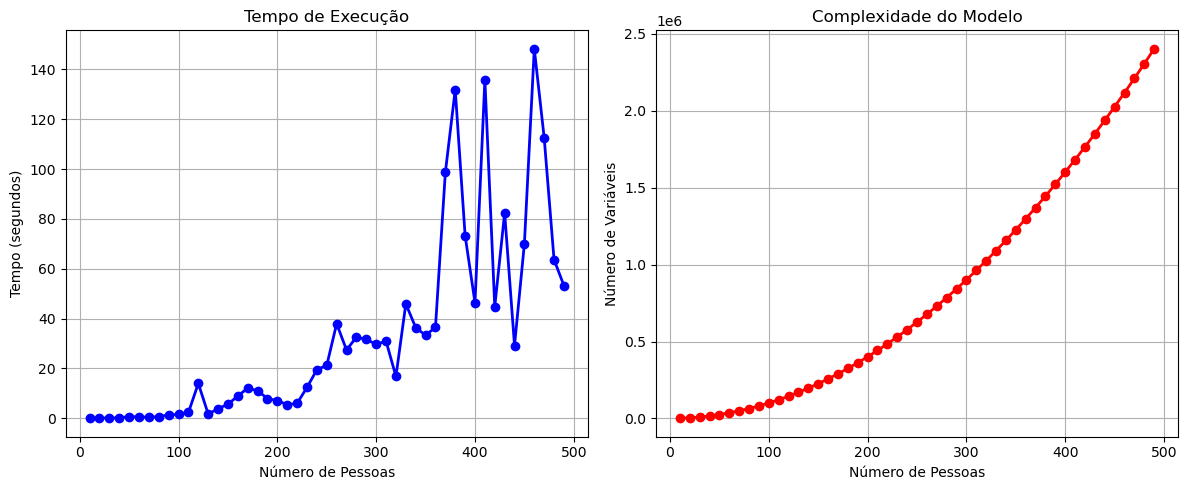

In [10]:
import time
import random
import matplotlib.pyplot as plt
import pandas as pd

def gerar_instancia(num_pessoas, seed=42):
    """Gera uma instância com 5 tarefas por pessoa"""
    num_tarefas = num_pessoas * 5
    random.seed(seed)
    
    pessoas = [f"P{i+1}" for i in range(num_pessoas)]
    tarefas = [f"T{i+1}" for i in range(num_tarefas)]
    
    capacidades = {p: random.randint(6, 10) for p in pessoas}
    duracoes = {t: random.randint(2, 6) for t in tarefas}
    prioridades = {t: random.randint(1, 10) for t in tarefas}
    penalidades = {t: prioridades[t] * 0.5 for t in tarefas}
    
    especialistas = {}
    for t in tarefas:
        for p in pessoas:
            if random.random() < 0.25:
                especialistas[(t, p)] = 1
    
    dependencias = []
    for i in range(num_tarefas - 1):
        if random.random() < 0.15:
            dependencias.append((tarefas[i], tarefas[i + 1]))
    
    return {
        'pessoas': pessoas,
        'tarefas': tarefas,
        'capacidades': capacidades,
        'duracoes': duracoes,
        'prioridades': prioridades,
        'penalidades': penalidades,
        'especialistas': especialistas,
        'dependencias': dependencias
    }

def testar_escalabilidade():
    """Testa diferentes tamanhos de problema"""
    resultados = []
    tamanhos = list(range(10, 500, 10))
    
    for num_pessoas in tamanhos:
        num_tarefas = num_pessoas * 5
        print(f"Testando {num_pessoas} pessoas ({num_tarefas} tarefas)...")
        
        instancia = gerar_instancia(num_pessoas)
        solver = AlocacaoTarefasScrum(**instancia)
        solver.criar_modelo()
        solver.modelo.Params.OutputFlag = 0
        
        inicio = time.time()
        solver.modelo.optimize()
        tempo = time.time() - inicio
        
        resultado = {
            'pessoas': num_pessoas,
            'tarefas': num_tarefas,
            'variaveis': solver.modelo.NumVars,
            'tempo': tempo
        }
        
        resultados.append(resultado)
    
    return pd.DataFrame(resultados)

def plotar_resultados(df):
    """Plota gráficos dos resultados"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Tempo vs Pessoas
    ax1.plot(df['pessoas'], df['tempo'], 'bo-', linewidth=2)
    ax1.set_xlabel('Número de Pessoas')
    ax1.set_ylabel('Tempo (segundos)')
    ax1.set_title('Tempo de Execução')
    ax1.grid(True)
    
    # Número de Variáveis
    ax2.plot(df['pessoas'], df['variaveis'], 'ro-', linewidth=2)
    ax2.set_xlabel('Número de Pessoas')
    ax2.set_ylabel('Número de Variáveis')
    ax2.set_title('Complexidade do Modelo')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Executar teste
df_resultados = testar_escalabilidade()

print("\nResultados:")
print(df_resultados)

df_resultados.to_csv('escalabilidade.csv', index=False)
plotar_resultados(df_resultados)